# Calculate potential intensity (PI) and TC genesis potential index (GPI) from the jra55 data
the sst data is from oisst
need to interpolate to the same grid


In [69]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import hvplot.xarray
# load PI calculation module
from tcpyPI import pi, cape
import time

In [43]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

## 1. Load Data and Code

In [46]:
dsst = xr.open_dataset('/glade/work/huili7/S2S/clim_data/oisst_climatology_2002-2019.nc')
sst = dsst.t


ds_t = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_t_2002-2019.nc')
temp = ds_t.t.sel(isobaricInhPa=slice(1000,100))
#temp_regrid = temp.interp(latitude=sst.latitude, longitude = sst.longitude, method='nearest')


ds_q = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_q_2002-2019.nc')
q = ds_q.q
#q_regrid = q.interp(latitude=sst.latitude, longitude = sst.longitude, method='nearest')


pres = q.isobaricInhPa * 1.


ds_ps = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_ps_2002-2019.nc')
ps = ds_ps.sp
#ps_regrid = ps.interp(latitude=sst.latitude, longitude = sst.longitude, method='nearest')


dsmask = xr.open_dataset('/gpfs/fs1/collections/rda/data/ds277.0/climatology/lsmask.nc')
lsm=dsmask.mask

In [48]:
temp

<xarray.DataArray 't' (month: 12, isobaricInhPa: 27, latitude: 145, longitude: 288)>
[13530240 values with dtype=float32]
Coordinates:
    number         int64 ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 ... 175 150 125 100
  * latitude       (latitude) float64 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude      (longitude) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      K
    long_name:  temperature

In [49]:
sst

<xarray.DataArray 't' (month: 12, latitude: 180, longitude: 360)>
[777600 values with dtype=float32]
Coordinates:
    step       timedelta64[ns] 00:00:00
    surface    int64 0
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  sea surface temperature
    units:      K

In [54]:
lsm1 = lsm.rename({'lat':'latitude'})
lsm2 = lsm1.rename({'lon':'longitude'})
sst = sst.where(lsm2[0]==1)
sst = sst - 273.15

### regrid SST

In [56]:
sst_regrid = sst.interp(latitude=temp.latitude, longitude = temp.longitude, 
                        method='linear')

In [60]:
sst_regrid

<xarray.DataArray 't' (month: 12, latitude: 145, longitude: 288)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -1.79998779, -1.79998779, ..., -1.79998779,
         -1.79998779, -1.79998779],
        [        nan, -1.79093933, -1.79000854, ..., -1.79859161,
         -1.79812622, -1.79736328],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -1.79998779, -1.79998779, ..., -1.79998779,
         -1.79998779, -1.79998779],
        [        nan, -1.78957367, -1.78942871, ..., -1.79866028,
         -1.79708862, -1.79650879],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -1.79998779, -1.79998779, ..., -1.79998779,
         -1.79998779, -1.79998779],
        [        nan, -1.78971863, -1.78942871, ..., -1.79795074,
         -1.79766846, -1.79751587],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    step       timedelta64[ns] 00:00:00
    surface    int64 0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    time       datetime64[ns] 1981-10-29
  * latitude   (latitude) float64 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    number     int64 0

## 2. Calculate potential intensity

In [61]:
# store the data in numpy arrays
SST_c,MSL,Ta_c,R,P=np.asarray(sst_regrid),np.asarray(ps * 0.01),np.asarray(temp - 273.15),np.asarray(q * 1000.),np.asarray(pres)

In [66]:
# find the sizes of the the arrays
nlat,nlon=sst_regrid.sizes['latitude'],sst_regrid.sizes['longitude']
# create arrays to store data
VMAXp,PMINp,TOp,LNBp=np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64'), \
    np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64')
IFLp=np.zeros((12,nlat,nlon),dtype='float64')
# fill with missing data
VMAXp[:],PMINp[:],TOp[:],LNBp[:],IFLp[:]=np.nan,np.nan,np.nan,np.nan,np.nan
# (VMAX,PMIN,IFL,TO,LNB)=pi(sst1,msl1,p1,t1,q1,CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,ptop=50,miss_handle=1)

### a little test for vertical profile

In [10]:
# choose a location and month
want_lat=10.5
want_lon=180.5
want_mon=9
# find the index of the profile
xi=np.where(dsst.longitude==want_lon)[0][0]
yi=np.where(dsst.latitude==want_lat)[0][0]
moni=int(want_mon)
# moni,yi,xi=0,19,76
# get the profile and input values
p1=P
t1=Ta_c[moni, :, yi,xi]
q1=R[moni,:,yi,xi]
sst1=SST_c[moni, yi,xi]
msl1=MSL[moni,yi,xi]


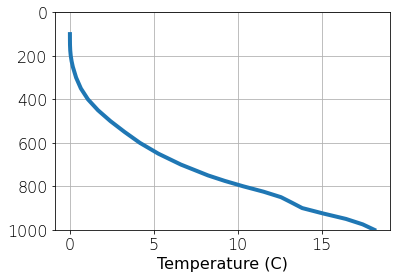

In [11]:
plt.figure()
plt.plot(q1,p1,lw=4)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
#plt.yscale('log')
plt.xlabel('Temperature (C)')
plt.grid()
plt.show()

In [10]:
import time

### get VMAX

In [70]:
# time the loop
start = time.time()

# loop over the data grid and calculate PI
for m in range(12):
    for x in range(nlon):
        for y in range(nlat):
            if (SST_c[m,y,x]>0.0):
                (VMAXp[m,y,x],PMINp[m,y,x],IFLp[m,y,x],TOp[m,y,x],LNBp[m,y,x]) = pi( \
                    SST_c[m,y,x],MSL[m,y,x],P,Ta_c[m,:,y,x],R[m,:,y,x],\
                    CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,ptop=50,miss_handle=1)
                
            
    

end = time.time()
print(end - start)

75.3812985420227


In [79]:
VMAXp.shape

(12, 145, 288)

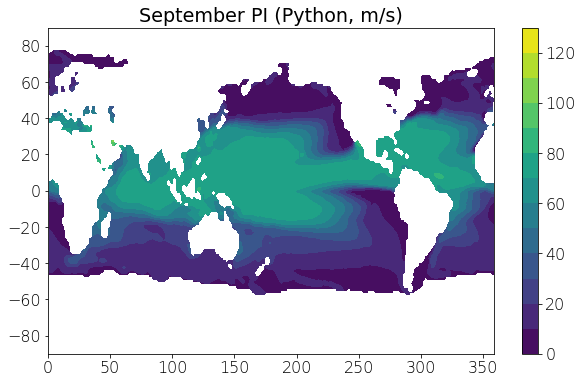

In [81]:
# plot both side by side in September
clevels=np.arange(0,140,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(sst_regrid.longitude,sst_regrid.latitude,VMAXp[8,:,:],clevels)

plt.title('September PI (Python, m/s)')
plt.colorbar()


plt.show()

In [86]:
VMAX = xr.DataArray(data=VMAXp,dims=['month','latitude','longitude'],coords={'month':sst_regrid.month,'latitude':sst_regrid.latitude.data,'longitude':sst_regrid.longitude.data})
PMIN = xr.DataArray(data=PMINp,dims=['month','latitude','longitude'],coords={'month':ds_ps.month,'latitude':ds_ps.latitude.data,'longitude':ds_ps.longitude.data})

In [89]:
VMAX.to_dataset(name='VMAX').to_netcdf("/glade/work/huili7/S2S/clim_data/jra_pi_VMAX.nc")
#PMIN.to_netcdf("/glade/work/huili7/S2S/jra_pi_VMAX.nc",'a')

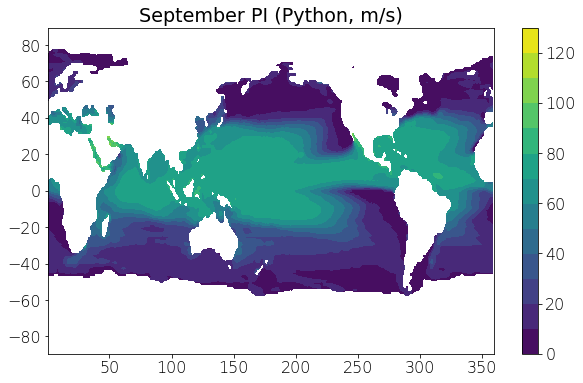

In [17]:
clevels=np.arange(0,140,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(dsst.longitude,dsst.latitude,VMAX[8,:,:],clevels)

plt.title('September PI (Python, m/s)')
plt.colorbar()


plt.show()

In [13]:
# ds = xr.open_dataset("/glade/work/huili7/S2S/clim_data/jra_pi_VMAX.nc")
# VMAX = ds.VMAX
# VMAX

<xarray.DataArray 'VMAX' (month: 12, latitude: 180, longitude: 360)>
[777600 values with dtype=float64]
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5

## 3. Calculate GPI

In [90]:
omega = 7.2921 * 1e-5 #rad/s

### Read in absolute vorticity and uv850, rh700, uv200

In [91]:
dsv = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv850_2002-2019.nc')
vor = dsv.vo + 2 * omega * np.sin(np.deg2rad(dsv.latitude)) 

In [92]:
u850 = dsv.u
v850 = dsv.v

In [93]:
dsr = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_rh700_2002-2019.nc')
dsr.r

<xarray.DataArray 'r' (month: 12, latitude: 145, longitude: 288)>
[501120 values with dtype=float32]
Coordinates:
    number         int64 ...
    step           timedelta64[ns] ...
    isobaricInhPa  int64 ...
  * latitude       (latitude) float64 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude      (longitude) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      %
    long_name:  700hPa RH

In [94]:
dsuv = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv200_2002-2019.nc')
u200 = dsuv.u
v200 = dsuv.v

In [95]:
shear = np.sqrt((u200 - u850)**2 + (v200-v850)**2) 

In [96]:
shear

<xarray.DataArray (month: 12, latitude: 145, longitude: 288)>
array([[[2.523308  , 2.5235794 , 2.5279412 , ..., 2.5209928 ,
         2.5200474 , 2.526024  ],
        [3.601117  , 3.601117  , 3.6091084 , ..., 3.5823078 ,
         3.5872023 , 3.601117  ],
        [4.3891797 , 4.3889446 , 4.41821   , ..., 4.342257  ,
         4.3419414 , 4.3865933 ],
        ...,
        [4.2288876 , 4.2270436 , 4.169125  , ..., 4.289217  ,
         4.287008  , 4.234119  ],
        [4.079682  , 4.079682  , 4.0868382 , ..., 4.0601172 ,
         4.065369  , 4.079682  ],
        [3.6723325 , 3.6710877 , 3.6717954 , ..., 3.6724167 ,
         3.6713543 , 3.67371   ]],

       [[2.8226936 , 2.8202481 , 2.8264756 , ..., 2.8238657 ,
         2.8242624 , 2.8314505 ],
        [3.403285  , 3.403285  , 3.41543   , ..., 3.3810537 ,
         3.3857281 , 3.403285  ],
        [4.009632  , 4.011998  , 4.040223  , ..., 3.9670355 ,
         3.9701583 , 4.0042405 ],
...
        [5.259867  , 5.251233  , 5.1356783 , ..., 5.3874946 ,
         5.377539  , 5.2659197 ],
        [5.041515  , 5.041515  , 5.0177326 , ..., 5.052193  ,
         5.048852  , 5.041515  ],
        [4.1583676 , 4.1642814 , 4.155003  , ..., 4.158464  ,
         4.156961  , 4.1580696 ]],

       [[2.3706    , 2.3677058 , 2.3669744 , ..., 2.3714032 ,
         2.372677  , 2.367874  ],
        [3.1516552 , 3.1516552 , 3.1538496 , ..., 3.1281726 ,
         3.1357543 , 3.1516552 ],
        [3.7678816 , 3.7679794 , 3.7851899 , ..., 3.7380297 ,
         3.7343197 , 3.7651832 ],
        ...,
        [4.7652516 , 4.7673054 , 4.7092223 , ..., 4.828124  ,
         4.8227444 , 4.767693  ],
        [4.6995955 , 4.6995955 , 4.7005615 , ..., 4.68966   ,
         4.6941257 , 4.6995955 ],
        [4.008582  , 4.0095086 , 4.007506  , ..., 4.008832  ,
         4.0088687 , 4.0090265 ]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
  * latitude   (latitude) float64 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### four terms for GPI

In [97]:
t_vor = np.abs(1e5 * vor)**(3/2)  # s**-3/2
t_rh =  (dsr.r / 50)**3 
t_pi =  (VMAX / 70)**3   # m3 s-3
t_shear = (1 + 0.1 * shear) ** -2    # m-2 s2

In [34]:
#t_vor_regrid = t_vor.interp(latitude=VMAX.latitude, longitude = VMAX.longitude, method='nearest')
#t_rh_regrid = t_rh.interp(latitude=VMAX.latitude, longitude = VMAX.longitude, method='nearest')
#t_shear_regrid = t_shear.interp(latitude=VMAX.latitude, longitude = VMAX.longitude, method='nearest')

In [99]:
gpi = t_vor * t_rh * t_pi * t_shear

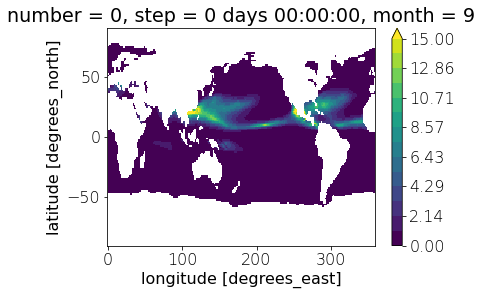

In [101]:
gpi[8].plot(levels=np.linspace(0,15,15))

In [102]:
gpi.to_dataset(name='gpi').to_netcdf('/glade/work/huili7/S2S/clim_data/jra_gpi_2002-2019.nc')